In [1]:
from GP import *
from GP_utils import *
import matplotlib.pyplot as plt
from pyDOE import lhs
import numpy as np
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3
    #set font size for titles 
mpl.rcParams['axes.titlesize'] = 15
    #set font size for labels on axes
mpl.rcParams['axes.labelsize'] = 17
    #set size of numbers on x-axis
mpl.rcParams['xtick.labelsize'] = 15
    #set size of numbers on y-axis
mpl.rcParams['ytick.labelsize'] = 15
   #set size of ticks on x-axis
mpl.rcParams['xtick.major.size'] = 7
    #set size of ticks on y-axis
mpl.rcParams['ytick.major.size'] = 7
    #set size of markers
mpl.rcParams['lines.markersize'] = 5
    #set number of examples shown in legends
mpl.rcParams['legend.numpoints'] = 2
    #set the size of the legend
mpl.rcParams['legend.fontsize']=10
    #Set the color of the edges
mpl.rcParams["axes.edgecolor"] = "0.15"
mpl.rcParams["axes.linewidth"]  = 3
plt.rcParams["figure.figsize"] = (10,8)

In [2]:
def f_H(x):
    return (6.0*x-2.0)**2 * np.sin(12.*x-4.0)

def f_L(x):
    return 0.5*f_H(x) + 10.0*(x-0.5) - 5.0

def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

# Multi-fidelity GP

In [18]:
np.random.seed(1234)
N_H = 4
N_L = 12
D = 1
lb = 0.0
ub = 1
noise_L = 0
noise_H = 0

Normalize_input_data = 1
Normalize_output_data = 1

# Training data    
X_L = lb + (ub-lb)*lhs(D,N_L)
y_L = f_L(X_L) + noise_L*np.random.randn(N_L,D)

X_H = np.linspace(0,1,N_H)[:,np.newaxis]
y_H = f_H(X_H) + noise_H*np.random.randn(N_H,D)

# Test data
nn = 200
X_star = np.linspace(lb, ub, nn)
y_star = f_H(X_star)

 #  Normalize Input Data
if Normalize_input_data == 1:
    X = np.vstack((X_L,X_H))
    X_m = np.mean(X, axis = 0)
    X_s = np.std(X, axis = 0)   
    X_L = Normalize(X_L, X_m, X_s)
    X_H = Normalize(X_H, X_m, X_s)
    lb = Normalize(lb, X_m, X_s)
    ub = Normalize(ub, X_m, X_s)
    X_star = Normalize(X_star, X_m, X_s)

#  Normalize Output Data
if Normalize_output_data == 1:
    y = np.vstack((y_L,y_H))
    y_m = np.mean(y, axis = 0)
    y_s = np.std(y, axis = 0)   
    y_L = Normalize(y_L, y_m, y_s)
    y_H = Normalize(y_H, y_m, y_s)
    y_star = Normalize(y_star, y_m, y_s)
    
hyp_mf = np.log(np.ones((D+1,)))
hyp_mf = np.concatenate([hyp_mf,hyp_mf])
rho = np.array([1])
logsigma_n = np.array([-4.0,-4.0])
hyp_mf = np.concatenate([hyp_mf,logsigma_n,rho])

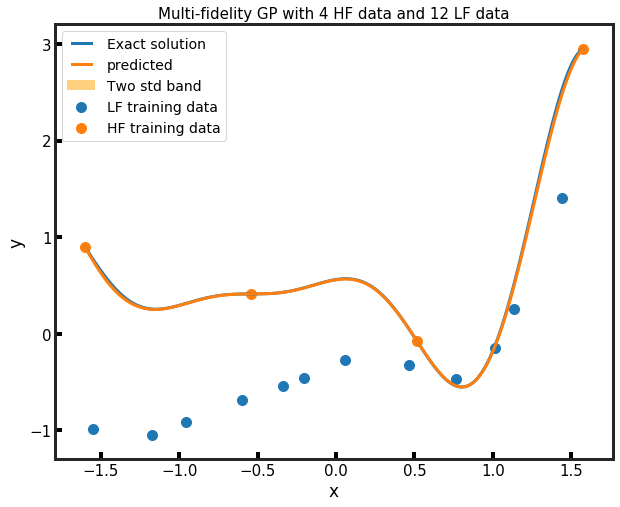

In [19]:
model_mf = multifidelity_GP(X_L,y_L,X_H,y_H,rbf_kernel,hyp_mf)
model_mf.train()
mu_mf,cov_mf = model_mf.predict(X_star[:,np.newaxis])
lower = mu_mf.flatten() - 2*np.sqrt(np.abs(np.diag(cov_mf)))
upper = mu_mf.flatten() + 2*np.sqrt(np.abs(np.diag(cov_mf)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.scatter(X_L,y_L,s=100,label='LF training data')
ax.scatter(X_H,y_H,s=100,label='HF training data')
ax.plot(X_star,y_star,label='Exact solution')
ax.plot(X_star,mu_mf,label='predicted')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Multi-fidelity GP with {} HF data and {} LF data".format(N_H,N_L))
ax.tick_params(direction='in',width=4)
ax.legend(fontsize=14)

# Gaussian Process

In [7]:
np.random.seed(1234)
hyp = np.log(np.ones((D+1,)))
logsigma_n = np.array([-4])
hyp = np.concatenate([hyp,logsigma_n])

hyp_p = np.log(np.ones((D+1,)))
l = np.log([2])
hyp_p = np.concatenate([hyp_p,l,logsigma_n])

N = 3
lb = 0
ub = 1
noise = 0 
Npoints = 100


X = lb+(ub-lb)*lhs(D,N)
y = f_H(X)+noise*np.random.randn(N,D)
ym,ys = y.mean(),y.std()
Xm,Xs = X.mean(),X.std()
X = Normalize(X,Xm,Xs)
y = Normalize(y,ym,ys)

Xtest = np.linspace(lb,ub,Npoints)[:,np.newaxis]
ytest = f_H(Xtest)
Xtest = Normalize(Xtest,Xm,Xs)
ytest = Normalize(ytest,ym,ys)

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.scatter(X,y,label="Training points",c='orange',s=100)
#ax.plot(Xtest,ytest,label="Exact solution")
#ax.tick_params(direction='in',width=4)
#ax.set_xlabel("X")
#ax.set_ylabel("y")
#ax.legend(fontsize=15)

model1 = GP(X,y,rbf_kernel,hyp)
model2 = GP(X,y,periodic_kernel,hyp_p)

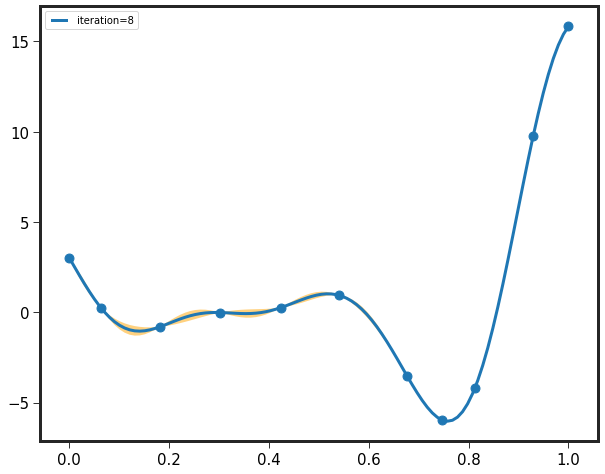

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(9):
    model1.train()
    mu,cov = model1.predict(Xtest)
    std = np.sqrt(np.abs(np.diag(cov)))
    idx = np.argmax(std)
    
    lower = mu.flatten() - 2*np.sqrt(np.abs(np.diag(cov)))
    upper = mu.flatten() + 2*np.sqrt(np.abs(np.diag(cov)))

    
    if i == 8:
        ax.scatter(X*Xs+Xm,y*ys+ym,s=80)
        ax.plot(Xtest*Xs+Xm,mu*ys+ym,label='iteration={}'.format(i))
        ax.fill_between(Xtest.flatten()*Xs+Xm, lower.flatten()*ys+ym, upper.flatten()*ys+ym, 
                facecolor='orange', alpha=0.5)
    new_point = np.array([Xtest[idx]])
    X = np.vstack((X,new_point))*Xs+Xm
    y = f_H(X)
    Xtest = Xtest*Xs+Xm
    
    
    Xm,Xs = X.mean(),X.std()
    X = (X-Xm)/Xs
    ym,ys = y.mean(),y.std()
    y = (y-ym)/ys
    Xtest = (Xtest-Xm)/Xs
    model1 = GP(X,y,rbf_kernel,hyp)
    
ax.legend()

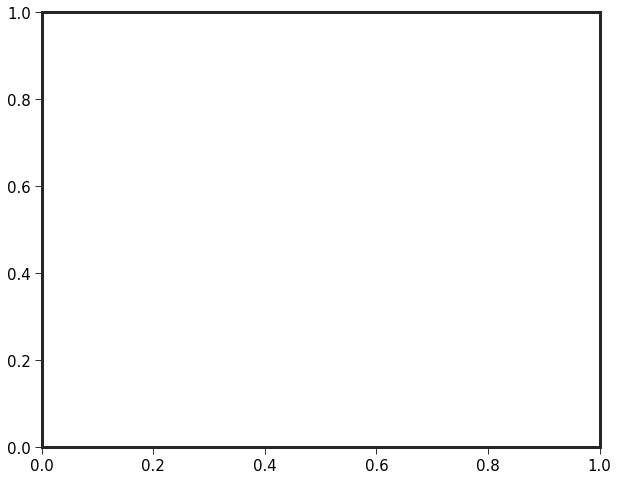

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(7):
    model1.train()
    k = model1.Expected_Improvement(Xtest)
    mu,cov = model1.predict(Xtest)
    lower = mu.flatten() - 2*np.sqrt(np.abs(np.diag(cov)))
    upper = mu.flatten() + 2*np.sqrt(np.abs(np.diag(cov)))
    
    idx = np.argmax(k)
    #ax.scatter(X,y)
    #ax.plot(Xtest,mu,label='iteration={}'.format(i))
    #ax.fill_between(Xtest.flatten(), lower.flatten(), upper.flatten(), 
    #            facecolor='orange', alpha=0.5)
    new_point = np.array([Xtest[idx]])
    y_new = (f_H(new_point*Xs+Xm)-ym)/ys
    X = np.vstack((X,new_point))
    y = np.vstack((y,y_new))
    model1 = GP(X,y,rbf_kernel,hyp)
    
#ax.legend()

Text(0.5, 1.0, 'GP with 10 training data')

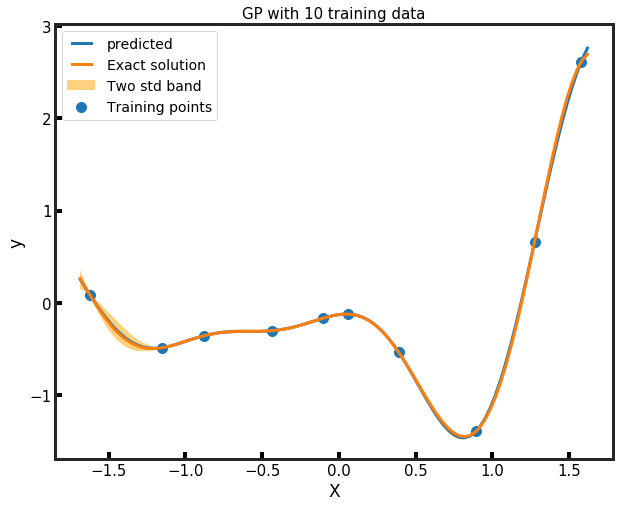

In [113]:
model1.train()
mu,cov,pos_samples = model1.draw_posterior(Xtest,20)
lower = mu.flatten() - 2*np.sqrt(np.abs(np.diag(cov)))
upper = mu.flatten() + 2*np.sqrt(np.abs(np.diag(cov)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(Xtest.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.plot(Xtest,mu.flatten(),label='predicted')
ax.plot(Xtest,ytest,label='Exact solution')
ax.scatter(X,y,label='Training points',s=100)
ax.tick_params(direction='in',width=4)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.legend(fontsize=14)
ax.set_title("GP with {} training data".format(N))

## Draw prior from prior distribution

Text(0.5, 1.0, 'Prior samples from RBF kernel')

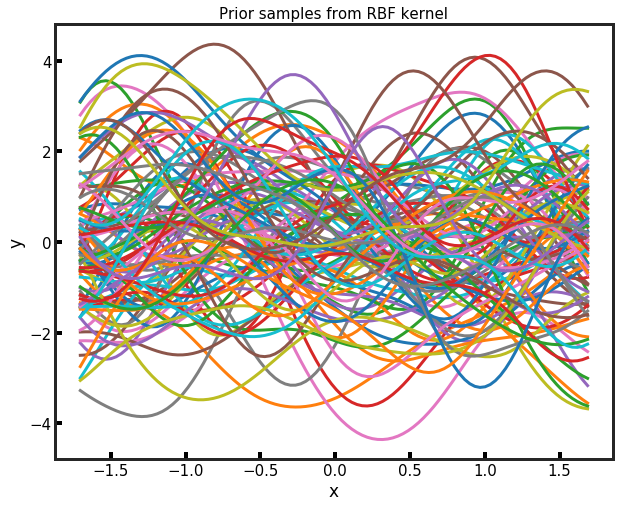

In [7]:
num_prior = 100


prior = model1.draw_prior(Xtest,100)
fig = plt.figure()
ax = fig.add_subplot(111)
for a in range(prior.shape[0]):
    ax.plot(Xtest,prior[a,:])
ax.tick_params(direction='in',width=4)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Prior samples from RBF kernel")

Text(0.5, 1.0, 'prior samples from periodic kernel')

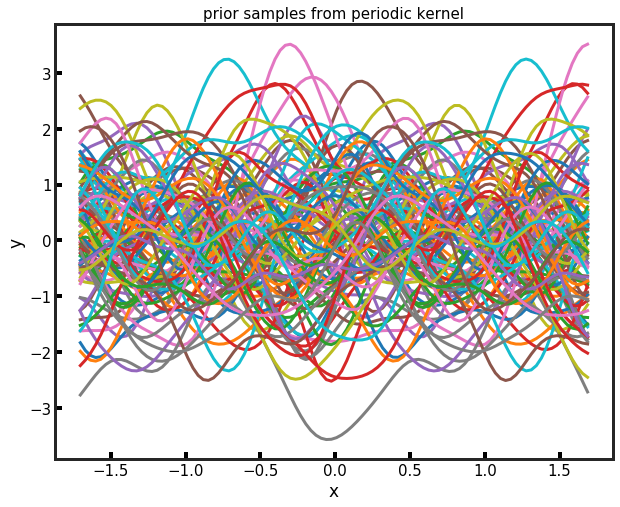

In [8]:
prior_p = model2.draw_prior(Xtest,num_prior)
fig = plt.figure()
ax = fig.add_subplot(111)
for d in range(prior_p.shape[0]):
    ax.plot(Xtest,prior_p[d])
ax.tick_params(direction='in',width=4)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("prior samples from periodic kernel")